# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 5

### **Vectores Embebidos Pre-entrenados: Fasttext**

#### **Nombres y matrículas de los integrantes del equipo:**



*   **Nombre:** Daniela Sánchez
*   **Matrícula:** A01749492

*   **Nombre:** Esteban Sánchez
*   **Matrícula:** A01740631



In [1]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import pickle
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from wordcloud import WordCloud
import matplotlib.pyplot as plt

##**Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [2]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Cargar los archivos de datos
amazon_df = pd.read_csv('Datos/amazon5.txt', sep='\t', header=None, names=['Review', 'Sentiment'])
imdb_df = pd.read_csv('Datos/imdb5.txt', sep='\t', header=None, names=['Review', 'Sentiment'])
yelp_df = pd.read_csv('Datos/yelp5.txt', sep='\t', header=None, names=['Review', 'Sentiment'])

# Concatenar los DataFrames
df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)

# *********** Aquí termina la sección de agregar código *************


In [3]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Review     3000 non-null   object 
 1   Sentiment  2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.0+ KB


In [4]:
# Y veamos sus primeros registros:

df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0.0
1,"Good case, Excellent value.",1.0
2,Great for the jawbone.,1.0
3,Tied to charger for conversations lasting more...,0.0
4,The mic is great.,1.0


##**Pregunta - 2:**

Realiza el proceso de limpieza.

Aplica el preprocesamiento que consideres adecuado, sin embargo, deberás aplicar necesariamente alguna de las técnicas de lematización.











In [5]:
# Listas de stopwords y negaciones a preservar
stop_words = set(stopwords.words('english'))  # Stopwords en inglés
negwords = {'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}

# Actualizar la lista de stopwords removiendo las negaciones
custom_stopwords = stop_words - negwords

print("Número de stopwords: ", len(custom_stopwords))
print("Ejemplo de stopwords:", list(custom_stopwords)[:10])

Número de stopwords:  139
Ejemplo de stopwords: ['him', 'more', 'by', 'we', "you'd", 'should', "she's", 'a', 'up', 'they']


In [6]:
# Preparar el lematizador y las stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Contracciones comunes y su expansión
contractions = {
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
    "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "couldn't": "could not", "shouldn't": "should not",
    "mightn't": "might not", "mustn't": "must not"
}

# Eliminar palabras negativas de stopwords
negwords = ['no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

mystopwords = stopwords.words('english')
for x in mystopwords:
    if x in negwords:
        mystopwords.remove(x)

def clean_text(review, sentiment):
    # Expandir contracciones
    for word in review.split():
        if word.lower() in contractions:
            review = review.replace(word, contractions[word.lower()])
    
    # Normalización y limpieza básica
    review = review.lower()
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Eliminar URLs
    review = re.sub(r'<.*?>', '', review)  # Eliminar HTML tags
    review = re.sub(r'[^a-z\s]', '', review)  # Se conservan solo letras y espacios

    # Tokenización
    tokens = word_tokenize(review)

    # Eliminación de stopwords
    tokens = [token for token in tokens if token not in mystopwords]

    # Eliminación selectiva de palabras en comentarios negativos y positivos
    if sentiment == 0:
        tokens = [token for token in tokens if token not in {'food', 'place', 'service', 'phone', 'time', 'good', 'one'}]
    else:
        tokens = [token for token in tokens if token not in {'service', 'place'}]

    # Lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Aplicar la limpieza con condición basada en el sentimiento
df['Clean_Review'] = df.apply(lambda row: clean_text(row['Review'], row['Sentiment']), axis=1)

# Verificar y eliminar filas con NaN en 'Clean_Review' o 'Sentiment'
df.dropna(subset=['Clean_Review', 'Sentiment'], inplace=True)

# Imprimir los primeros datos limpios
print(df[['Review', 'Clean_Review']].head())

# Filtrar los comentarios positivos y negativos
positive_reviews = df[df['Sentiment'] == 1][['Review', 'Clean_Review']]
negative_reviews = df[df['Sentiment'] == 0][['Review', 'Clean_Review']]

# Imprimir los primeros 5 comentarios positivos
print("Comentarios Positivos - Original y Limpio:")
print(positive_reviews.head())

# Imprimir los primeros 5 comentarios negativos
print("\nComentarios Negativos - Original y Limpio:")
print(negative_reviews.head())

                                              Review  \
0  So there is no way for me to plug it in here i...   
1                        Good case, Excellent value.   
2                             Great for the jawbone.   
3  Tied to charger for conversations lasting more...   
4                                  The mic is great.   

                                        Clean_Review  
0                  no way plug u unless go converter  
1                          good case excellent value  
2                                      great jawbone  
3  tied charger conversation lasting minutesmajor...  
4                                          mic great  
Comentarios Positivos - Original y Limpio:
                                         Review               Clean_Review
1                   Good case, Excellent value.  good case excellent value
2                        Great for the jawbone.              great jawbone
4                             The mic is great.                  

In [7]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:

Xclean = df['Clean_Review'].head(5).tolist()
for x in Xclean:
  print(x)


no way plug u unless go converter
good case excellent value
great jawbone
tied charger conversation lasting minutesmajor problem
mic great


#**Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [8]:

# ************* Inicia la sección de agregar código:*****************************

# Dividir los datos en conjuntos de entrenamiento y temporal
x_train, x_temp, y_train, y_temp = train_test_split(
    df['Clean_Review'], df['Sentiment'], test_size=0.30, random_state=42)

# Dividir el conjunto temporal en validación y prueba
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42)

# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 1400 1400
X,y Val: 300 300
X,y Test 300 300


#**Pregunta - 4:**



Construye tu vocabulario a continuación


In [9]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

word_counts = Counter(word for sentence in x_train for word in sentence.split())# Frecuencia de cada palabra
vocab = {word for word, count in word_counts.items() if count >= 3 and len(word) >= 3} # Filtrar palabras 

# *********** Aquí termina la sección de agregar código *************

In [10]:
# b.	Indica el tamaño del vocabulario generado.

print('Longitud del vocabulario generado:', len(vocab))

Longitud del vocabulario generado: 592


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Es importante usar solo el conjunto de entrenamiento para generar el vocabulario para evitar contaminar los datos de validación y prueba, y para mantener la integridad de la evaluación del modelo. Si incluimos palabras del conjunto de validación o prueba, estaríamos introduciendo información en el modelo durante la fase de entrenamiento, lo cual podría llevar a una evaluación sesgada y poco confiable del desempeño real del modelo.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [11]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Función para filtrar palabras basadas en el vocabulario
def filter_words(sentence):
    return ' '.join(word for word in sentence.split() if word in vocab)

# Aplicar filtro a los conjuntos de datos
train_x = x_train.apply(filter_words)
val_x = x_val.apply(filter_words)
test_x = x_test.apply(filter_words)

# *********** Aquí termina la sección de agregar código *************


In [12]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

horrible horrible
barely ever hear
purchased family friend enjoy clarity ease use
possible give zero star
buffet small bland


#**Pregunta - 5:**


a. Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de Google y Glove de Stanford.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

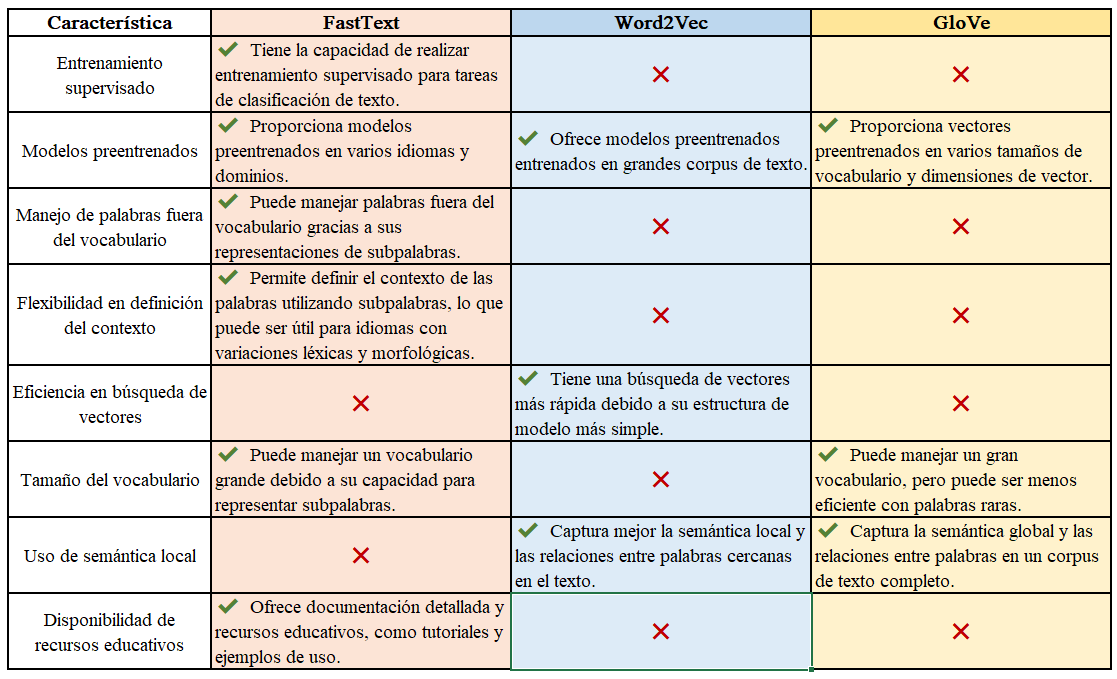

Tabla realizada en Excel con la información encontrada en las páginas refereciadas en el pdf de instrucciones.

### ++++++++ Termina la sección de agregar texto: +++++++++++


#**Pregunta - 6:**

Utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300 para generar un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el “valor” será su vector embebido de dimensión 300.

Este diccionario deberá ser del mismo tamaño que el vocabulario previo que hayas construido previamente.

Es recomendable que una vez que generes el nuevo vocabulario de vectores embebidos, guardes dicho diccionario en un archivo.

Recuerda borrar la variable donde descargaste los 2 millones de vectores embebidos Fasttext.



In [13]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

import requests
import gzip
import shutil

# URL del archivo FastText
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz"
response = requests.get(url, stream=True)

# Guardar el archivo gz descargado
with open("cc.en.300.vec.gz", 'wb') as f:
    f.write(response.content)

# Descomprimir el archivo
with gzip.open('cc.en.300.vec.gz', 'rb') as f_in:
    with open('cc.en.300.vec', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

fasttext_vectors = {}
with open("cc.en.300.vec", "r", encoding="utf-8") as file:
    next(file)  # Saltar la primera línea con la cuenta de palabras y dimensiones
    for line in file:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float32)
        fasttext_vectors[word] = vector

words_found = 0
embedding_dict = {}

for word in vocab:
    if word in fasttext_vectors:
        embedding_dict[word] = fasttext_vectors[word]
        words_found += 1
    else:
        embedding_dict[word] = np.zeros(300)  # Asumiendo que cada vector tiene 300 dimensiones

# Impresión de la información solicitada
print(f"Total de palabras en el vocabulario: {len(vocab)}")
print(f"Total de palabras cargadas desde FastText: {words_found}")
print(f"Total de palabras en el modelo FastText: {len(fasttext_vectors)}")

# *********** Aquí termina la sección de agregar código *************


Total de palabras en el vocabulario: 592
Total de palabras cargadas desde FastText: 592
Total de palabras en el modelo FastText: 2000000


#**Pregunta - 7:**



Generamos los vectores embebidos a paertir de los conjuntos de entrenamiento, validación y preuba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [14]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

import numpy as np

def comment_to_vector(comment, embedding_dict):
    # Dividir el comentario en palabras y filtrar aquellas que no están en el diccionario
    words = [word for word in comment.split() if word in embedding_dict and embedding_dict[word] is not None]
    # Obtener los vectores para las palabras filtradas
    if words:
        vectors = [embedding_dict[word] for word in words]
        # Calcular el vector promedio
        vector = np.mean(vectors, axis=0)
    else:
        # Si no hay palabras válidas en el comentario, retornar un vector de ceros
        vector = np.zeros(300)  # Asumiendo que la dimensión del vector es 300
    return vector

# Aplicar la función a cada conjunto de datos
trainEmb = np.array([comment_to_vector(comment, embedding_dict) for comment in train_x])
valEmb = np.array([comment_to_vector(comment, embedding_dict) for comment in val_x])
testEmb = np.array([comment_to_vector(comment, embedding_dict) for comment in test_x])

# *********** Aquí termina la sección de agregar código *************

In [15]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (1400, 300)
Val-Emb: (300, 300)
Test-Emb: (300, 300)


#**Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [31]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Entrenar el modelo de Regresión Logística
logistic_model = LogisticRegression(max_iter=100, C=1.0)
logistic_model.fit(trainEmb, y_train)

# Calcular y mostrar la exactitud de entrenamiento y validación
train_accuracy_logistic = logistic_model.score(trainEmb, y_train) * 100
val_accuracy_logistic = logistic_model.score(valEmb, y_val) * 100

print("Resultados para Regresión Logística:")
print(f'LR: Train-accuracy: {train_accuracy_logistic:.2f}%')
print(f'LR: Val-accuracy: {val_accuracy_logistic:.2f}%')

# *********** Aquí termina la sección de agregar código *************


Resultados para Regresión Logística:
LR: Train-accuracy: 85.07%
LR: Val-accuracy: 82.33%


In [30]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Entrenar el modelo de Bosque Aleatorio
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(trainEmb, y_train)

# Calcular y mostrar la exactitud de entrenamiento y validación
train_accuracy_forest = random_forest_model.score(trainEmb, y_train) * 100
val_accuracy_forest = random_forest_model.score(valEmb, y_val) * 100

print("Resultados para Random Forest:")
print(f'\nRF: Train-accuracy: {train_accuracy_forest:.2f}%')
print(f'RF: Val-accuracy: {val_accuracy_forest:.2f}%')

# *********** Aquí termina la sección de agregar código *************

Resultados para Random Forest:

RF: Train-accuracy: 98.93%
RF: Val-accuracy: 83.00%


#**Pregunta - 9:**



Reporte del mejor modelo.


In [29]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Predicciones en el conjunto de prueba
y_pred_test = logistic_model.predict(testEmb)

# Calcular la exactitud y otros indicadores de rendimiento
accuracy_test = accuracy_score(y_test, y_pred_test) * 100  # Convertir a porcentaje
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

# Mostrar los resultados
print("Resultados en el Conjunto de Prueba para la Regresión Logística:")
print(f"Exactitud: {accuracy_test:.2f}%")  # Formatear como número flotante con dos decimales
print("Matriz de Confusión:")
print(conf_matrix)
print("Reporte de Clasificación:")
print(class_report)

# *********** Aquí termina la sección de agregar código *************


Resultados en el Conjunto de Prueba para la Regresión Logística:
Exactitud: 83.00%
Matriz de Confusión:
[[137  30]
 [ 21 112]]
Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       167
         1.0       0.79      0.84      0.81       133

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



#**Pregunta - 10:**

Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++


Para esta tarea empezamos unificando los datos de Amazon, IMDb y Yelp en un único DataFrame, seguido de una limpieza (tokenización, eliminación de caracteres especiales y lematización). Luego, generamos un vocabulario relevante usando el conjunto de entrenamiento y filtramos los conjuntos de entrenamiento, validación y prueba para incluir solo palabras de este vocabulario.

Luego, implementamos vectores embebidos preentrenados de FastText para representar las palabras y calculamos el vector promedio de las palabras para cada comentario, transformándolo en un vector de dimensión fija de 300 dimensiones. Después de eso, entrenamos y evaluamos los modelos de Regresión Logística y Bosque Aleatorio, calculando métricas de exactitud y generando reportes de clasificación, destacando la Regresión Logística por su simplicidad.

Al final,  el modelo de Regresión Logística es el mas optimo en este caso, El random forest tiene una ligera ventaja en términos de exactitud en el conjunto de validación. Sin embargo, muestra signos de sobreajuste, ya que la exactitud en el conjunto de entrenamiento es mucho mayor que en el conjunto de validación. Por otro lado, la regresión logística tiene una menor diferencia entre las exactitudes de entrenamiento y validación, lo que indica un modelo más generalizable con menos sobreajuste.

Esta tarea nos brindo un mejor manejo de datos de texto. sobretodo lo referente a la importancia del preprocesamiento, la utilidad de los vectores embebidos y la evaluación rigurosa de modelos.

### ++++++++ Termina la sección de agregar texto: +++++++++++

##**Fin de la Actividad de vectores Embebidos - FastText**